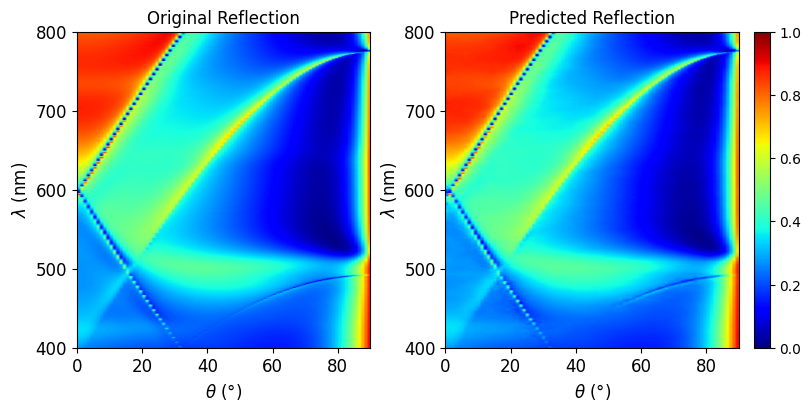

In [1]:
#prediction plots of forward model 
#the forward model predict the latent vector from the input structure
#then latent vector would be the input of the decoder of the Autoencoder
#for better comparison the predicted reflection spectra and the original reflection spectra corresponds to the structure is plotted next to each other

import torch
import os
import cv2
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
import sys
sys.path.append('/path to codes/')
from Reflection_Structure_DataLoader import ReflStrDataLoader
from Models import Autoencoder, StructureToLatent

def load_structure_to_latent_model(model_path, input_dim=3, output_dim=128, device='cpu'):
    model = StructureToLatent(input_dim=input_dim, output_dim=output_dim)
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
    model.eval()
    return model

structure_to_latent_model = load_structure_to_latent_model("/path to forward model/Forward_model_Strtolatent_optuna_NoisyAE.pth", device=device)

autoencoder = Autoencoder(latent_dim=128)
autoencoder.load_state_dict(torch.load("/path to autoencoder model/autoencoder_model_128_noise.pth", map_location=device, weights_only=True))
autoencoder.to(device)
autoencoder.eval()

def predict_and_reconstruct(structure_data, model, autoencoder, device='cpu'):
    model.eval()
    autoencoder.eval()
    structure_tensor = torch.tensor(structure_data, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        predicted_latent = model(structure_tensor)
        reconstructed_reflection = autoencoder.decoder(predicted_latent)
        _, _, H_out, W_out = reconstructed_reflection.shape
        H_target, W_target = 401, 91
        crop_h_start = (H_out - H_target) // 2
        crop_h_end = crop_h_start + H_target
        crop_w_start = (W_out - W_target) // 2
        crop_w_end = crop_w_start + W_target

        cropped = reconstructed_reflection[:, :, crop_h_start:crop_h_end, crop_w_start:crop_w_end]  
        reconstructed_reflection = cropped.squeeze(0).squeeze(0).cpu().numpy()
    
    return reconstructed_reflection

def plot_reflection_comparison(reconstructed_reflection, actual_reflection):
    fig = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)
    
    reconstructed_reflection = reconstructed_reflection.squeeze()

    plt.subplot(1, 2, 1)
    plt.imshow(actual_reflection, cmap='jet', aspect='auto', extent=[0, 90, 400, 800], origin='lower', vmin = 0, vmax = 1)
    plt.title('Original Reflection', fontsize=12)
    # plt.colorbar()
    plt.xticks(np.arange(0, 90, 20), size = 12)
    plt.yticks(np.arange(400, 801, 100), size = 12)
    plt.xlabel(r"$\theta$ (°)", fontsize=12)
    plt.ylabel(r"$\lambda$ (nm)", fontsize=12)
    
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_reflection, cmap='jet', aspect='auto', extent=[0, 90, 400, 800], origin='lower', vmin = 0, vmax = 1)
    plt.title('Predicted Reflection', fontsize=12)
    plt.colorbar()
    plt.xticks(np.arange(0, 90, 20), size = 12)
    plt.yticks(np.arange(400, 801, 100), size = 12)
    plt.xlabel(r"$\theta$ (°)", fontsize=12)
    plt.ylabel(r"$\lambda$ (nm)", fontsize=12)
    plt.savefig('ForwardOriginalPredicted.png', dpi=600, bbox_inches='tight')
    plt.show()
    
min_values = [10, 0, 280]  
max_values = [100, 1500, 550]  
    
def min_max_scaler(values, min_values, max_values):
    scaled_values = [(value - min_val) / (max_val - min_val) for value, min_val, max_val in zip(values, min_values, max_values)]
    return scaled_values

def revert_min_max_scaler(normalized_value, min_value, max_value):
    return normalized_value * (max_value - min_value) + min_value
for i in range(2, 3):
    structure = pd.read_csv("/path to data/Structure_" + str(i) + ".csv", header=0)
    structure_data = structure.apply(lambda row: min_max_scaler(row, min_values, max_values), axis=1)

    reflection = pd.read_csv("/path to data/Reflection_TM_" + str(i) + ".csv", header=None)
    reflection = reflection.iloc[1:, 1:].astype(float)
    actual_reflection = reflection.values

    reconstructed_reflection = predict_and_reconstruct(structure_data, structure_to_latent_model, autoencoder, device=device)

    plot_reflection_comparison(reconstructed_reflection, actual_reflection)
